# 2 Unsupervised Language Model

- 2.1 Initialisation
- 2.2 Training
- 2.3 Evaluation

## 2.1 Initialisation

In [95]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [96]:
import pandas as pd
from pathlib import Path
from functools import partial

from utils import tok_fixed, tok_variable, get_model_LM
import sys; sys.path.append("../tools"); from config import *

In [4]:
df_iter = pd.read_csv(HUMAN/'human_genome_data_fa.csv', chunksize=NROWS_TRAIN+NROWS_VAL)
df = next(df_iter)

# set val to be first 20k rows
df_tr = df[:NROWS_TRAIN]
df_va = df[NROWS_TRAIN:NROWS_TRAIN+NROWS_VAL]

In [4]:
MODEL_CONFIG = dict(emb_sz=400, 
                    n_hid=1150, 
                    n_layers=3, 
                    pad_token=0, 
                    qrnn=False, 
                    output_p=0.25, 
                    hidden_p=0.1, 
                    input_p=0.2, 
                    embed_p=0.02, 
                    weight_p=0.15, 
                    tie_weights=True, 
                    out_bias=True)

DROP_MULT   = 0.3

## Generate data

To calculate the required batch size to fit on CUDA, we can use the inverse proportionality of batch size with number of features, which is 4^n_gram. We know that a batch of 4^3 features will need to be 4^3/4^2 = 4 times smaller than for 4^2 features.

In [5]:
experiments = []

# fixed length
for i,ngram_stride in enumerate(NGRAM_STRIDE):
    experiment = {}
    experiment['title'] = 'fixed_{}_{}_rows_{}'.format(*ngram_stride,NROWS_TRAIN)
    experiment['xdata'], experiment['vocab'] = tok_fixed(df_tr, df_va, *ngram_stride, bs=BS[i])
    
    experiments.append(experiment)

# variable length   
for i,max_vocab in enumerate(MAX_VOCAB):
    experiment = {}
    experiment['title'] = 'variable_{}_rows_{}'.format(max_vocab,NROWS_TRAIN)    
    experiment['xdata'], experiment['vocab'] = tok_variable(df_tr, df_va, max_vocab, bs=BS[i])
    
    experiments.append(experiment)

## 2.2 Language Model Training

In [34]:
def train_model(experiment, epochs=10):
    import torch; import os
    config      = MODEL_CONFIG.copy()
    drop_mult   = DROP_MULT
    
    data  = experiment['xdata']
    learn = get_model_LM(data, drop_mult, config)
    learn = learn.to_fp16(dynamic=True); # convert model weights to 16-bit float
    
    model = 'models/' + experiment['title'] + '.pth'
    if os.path.exists(HUMAN/model):
        print('model found: loading model: {}'.format(experiment['title']))
        learn.load(experiment['title'])
        learn.data = data

    # add callbacks
    from fastai.callbacks.csv_logger import CSVLogger
    learn.callback_fns.append(partial(CSVLogger, 
                                      filename='history_' + experiment['title'], 
                                      append=True))
    
    learn.fit_one_cycle(epochs, 5e-3, moms=(0.8, 0.7))
    learn.save(experiment['title'])
    learn.save_encoder(experiment['title']+'_enc')
    
    # free up cuda
    del learn; del data; torch.cuda.empty_cache()

# for experiment in experiments[3:]:
#     print(experiment['title'])
#     train_model(experiment, epochs=8)

---

## 2.3 Validation

In [116]:
def plot_losses(learn):
    import matplotlib.pyplot as plt
    fig,ax = plt.subplots(2,1,figsize=(8,12))
    ax[0].plot(list(range(len(learn.recorder.val_losses))),learn.recorder.val_losses, label='Validation loss')
    ax[0].plot(list(range(len(learn.recorder.val_losses))),
               [learn.recorder.losses[i] for i in range(len(learn.recorder.val_losses),
                                                        len(learn.recorder.losses),
                                                        len(learn.recorder.losses)//len(learn.recorder.val_losses))], 
               label='Training loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].legend(loc='upper right')
    ax[1].plot(list(range(len(learn.recorder.val_losses))),learn.recorder.metrics)
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')

def train_sequence(experiment):
    config      = MODEL_CONFIG.copy()
    drop_mult   = DROP_MULT
    data,vocab  = generate_variable_vocab(df_tr, df_va, 64)
    learn = get_model_LM(data, drop_mult, config)
    learn = learn.to_fp16(dynamic=True); # convert model weights to 16-bit float
    
    count = 0
    lr = 5e-3
    for df in df_iter:
        data,_ = generate_variable_vocab(df, df_va, 64)
        learn.data = data                        
        lr_iter = lr/1.5**count
        print(f'Learning Rate: {lr_iter}')
        learn.fit_one_cycle(1, lr_iter, moms=(0.8,0.7))
        count += 1
        
        plot_losses(learn)
        
def plot_experiments(files, titles, values=['accuracy'], suptitle='lncRNA vs mRNA Classification Performance', 
                     xlabel='Epochs', ylabel='lncRNA vs mRNA Classification Accuracy', savefig=True):

    import matplotlib.pyplot as plt
    fig, axes = plt.subplots(nrows=1,ncols=3, figsize = (24,8))
    _=fig.suptitle(suptitle)
    plt.subplots_adjust(hspace=0.6)
    for i,(fixed,var) in enumerate(files):
        df = pd.read_csv(fixed)[values].rename({value:value+'_fixed' for value in values}, axis='columns')
        df.plot(ax=axes[i])
        df = pd.read_csv(var)[values].rename({value:value+'_var' for value in values}, axis='columns')
        axes[i].set_title(titles[i]); 
#         axes[i].set_ylim([0.4,1])
        _=axes[i].set_xlabel(xlabel); _=axes[i].set_ylabel(ylabel)
        df.plot(ax=axes[i])
    if savefig:
        fig.savefig(FIGURES/'ulmfit'/suptitle.lower().replace(' ','_'), dpi=fig.dpi, bbox_inches='tight', pad_inches=0.5)

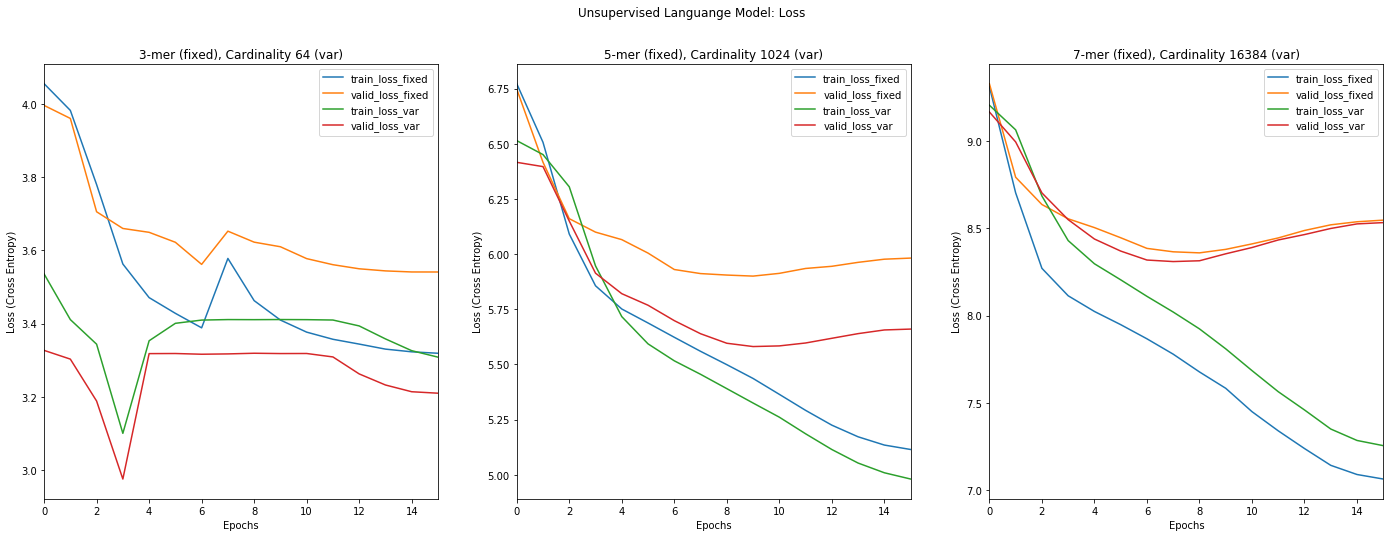

In [109]:
pairs   = [('3_3','64'),('5_5','1024'),('7_7','16384')]
titles  = ['3-mer (fixed), Cardinality 64 (var)',
           '5-mer (fixed), Cardinality 1024 (var)',
           '7-mer (fixed), Cardinality 16384 (var)'] 

files = [(glob.glob(str(HUMAN/'history_f')+'*'+pair[0]+'*')[0],
  glob.glob(str(HUMAN/'history_v')+'*'+pair[1]+'*')[0])for pair in pairs]

plot_experiments(files, titles, values=['train_loss','valid_loss'], suptitle='Unsupervised Languange Model: Loss', 
                     xlabel='Epochs', ylabel='Loss (Cross Entropy)')

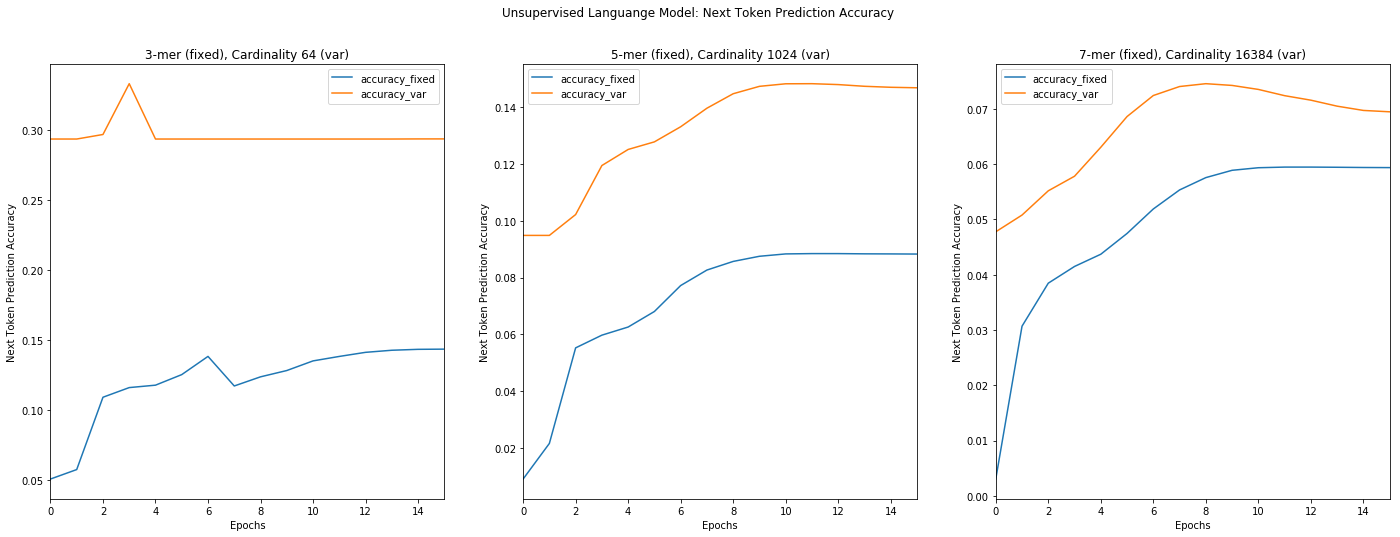

In [110]:
pairs   = [('3_3','64'),('5_5','1024'),('7_7','16384')]
titles  = ['3-mer (fixed), Cardinality 64 (var)',
           '5-mer (fixed), Cardinality 1024 (var)',
           '7-mer (fixed), Cardinality 16384 (var)'] 

files = [(glob.glob(str(HUMAN/'history_f')+'*'+pair[0]+'*')[0],
glob.glob(str(HUMAN/'history_v')+'*'+pair[1]+'*')[0])for pair in pairs]

plot_experiments(files, titles, values=['accuracy'], 
                 suptitle='Unsupervised Languange Model: Next Token Prediction Accuracy', 
                 xlabel='Epochs', ylabel='Next Token Prediction Accuracy')

---


In [ ]:
# %load_ext tensorboard

In [ ]:
# import tensorboardX
# from fastai.callbacks.tensorboard import LearnerTensorboardWriter
# from pathlib import Path

# project_id = 'exp1'
# tboard_path = Path('./logs/' + project_id)
# learn.callback_fns.append(partial(LearnerTensorboardWriter, 
#                                     base_dir=tboard_path, 
#                                     name='run1'))


---

In [15]:
import sys; sys.path.append("../tools"); from config import *
from utils import *

In [16]:
data_df = pd.read_csv(HUMAN/'lncRNA.csv', usecols=['Sequence','Name'])

# data for LM fine-tuning
df_ulm              = (data_df[data_df['Name'].str.contains('TRAIN.fa')].pipe(partition_data))
df_tr_,df_va_       = df_ulm[df_ulm.set == 'train'], df_ulm[df_ulm.set == 'valid']

# dfs for classification
df_clas             = (data_df[data_df['Name'].str.contains('train16K')].pipe(partition_data))
df_clas['Target']   = df_clas['Name'].map(lambda x : x.split('.')[0][:-1])
df_tr,df_va         = df_clas[df_clas.set == 'train'], df_clas[df_clas.set == 'valid']
df_te               = data_df[data_df['Name'].str.contains('TEST500')]

In [18]:
%%time
def make_experiments(df_tr, df_va):
    """Construct experiment based on tokenisation parameters explored.
    """
    experiments = []

    # fixed length
    for i,ngram_stride in enumerate(NGRAM_STRIDE):
        experiment = {}
        experiment['title'] = 'fixed_{}_{}_rows_{}'.format(*ngram_stride,NROWS_TRAIN)
        experiment['xdata'], experiment['vocab'] = tok_fixed(df_tr, df_va, *ngram_stride, 
                                                             bs=400, clas=True)

        experiments.append(experiment)

    # variable length   
    for i,max_vocab in enumerate(MAX_VOCAB):
        experiment = {}
        experiment['title'] = 'variable_{}_rows_{}'.format(max_vocab,NROWS_TRAIN)
        experiment['xdata'], experiment['vocab'] = tok_variable(df_tr, df_va, max_vocab, 
                                                                bs=400, clas=True)

        experiments.append(experiment)
        
    return experiments

experiments = make_experiments(df_tr, df_va)

CPU times: user 43.5 s, sys: 9.42 s, total: 52.9 s
Wall time: 42.6 s


In [23]:
CLAS_CONFIG     = dict(emb_sz=400, 
                       n_hid=1150, 
                       n_layers=3, 
                       pad_token=0, 
                       qrnn=False, 
                       output_p=0.4,
                       hidden_p=0.2, 
                       input_p=0.6,
                       embed_p=0.1, 
                       weight_p=0.5)
CLAS_DROP_MULT  = 0.5

def tune_classifier(experiment, epochs=1):
    config      = CLAS_CONFIG.copy()
    drop_mult   = CLAS_DROP_MULT

    data  = experiment['xdata']
    learn = get_model_clas(data, CLAS_DROP_MULT, CLAS_CONFIG.copy(), max_len=4000*70)
    learn.load_encoder('tune_'+experiment['title']+'_enc')
    learn = learn.to_fp16(dynamic=True);
    
    # add callbacks
    from fastai.callbacks.csv_logger import CSVLogger
    learn.callback_fns.append(partial(CSVLogger, 
                                      filename='history_clas2_' + experiment['title']))
    
    learn.freeze()
    learn.fit_one_cycle(epochs, 5e-2, moms=(0.8, 0.7))
    learn.save('clas2_'+experiment['title'])
    learn.save_encoder('clas2_'+experiment['title']+'_enc')
    
for experiment in experiments[-1:]:
    tune_classifier(experiment, epochs=8)

epoch,train_loss,valid_loss,accuracy,time
0,0.521010,0.459264,0.786721,00:25
1,0.511608,0.442811,0.793454,00:25
2,0.518746,0.416281,0.816474,00:25
3,0.515063,0.418581,0.809897,00:25
4,0.510149,0.411710,0.810836,00:26
5,0.499135,0.413150,0.816160,00:26
6,0.486530,0.397747,0.822737,00:25
7,0.486349,0.397813,0.823990,00:26


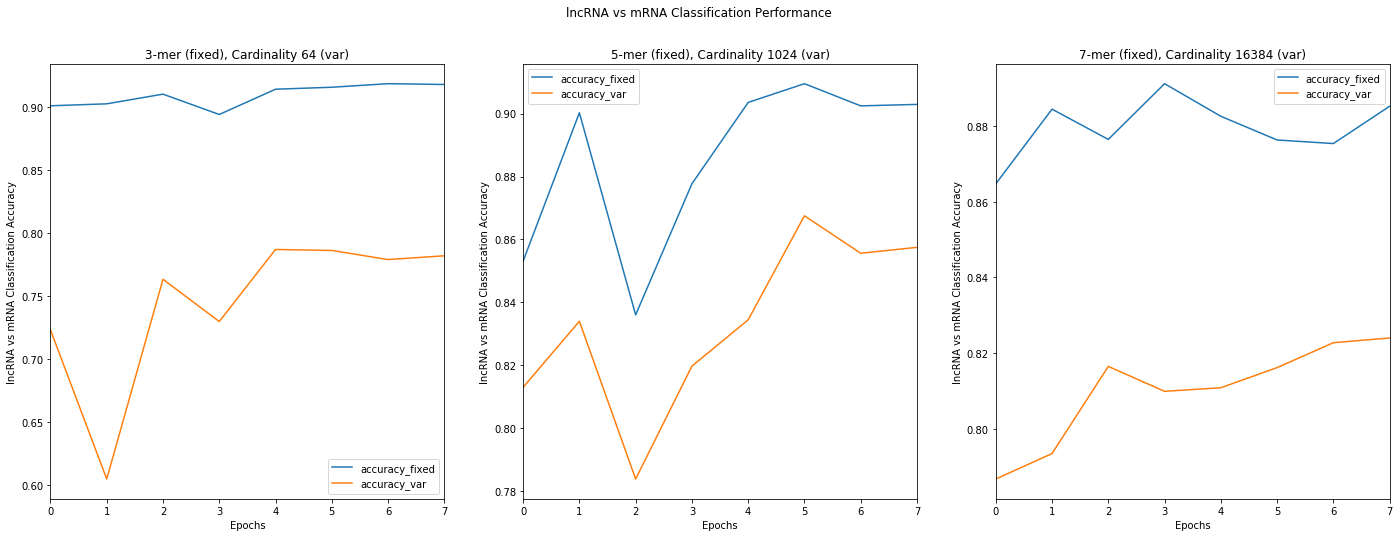

In [117]:
import glob
pairs   = [('3_3','64'),('5_5','1024'),('7_7','16384')]
titles  = ['3-mer (fixed), Cardinality 64 (var)',
           '5-mer (fixed), Cardinality 1024 (var)',
           '7-mer (fixed), Cardinality 16384 (var)'] 

files = [(glob.glob(str(HUMAN/'history_clas2_f')+'*'+pair[0]+'*')[0],
  glob.glob(str(HUMAN/'history_clas2_v')+'*'+pair[1]+'*')[0])for pair in pairs]
        
plot_experiments(files, titles)

---
---